In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
pd.set_option('display.max_columns',None)



from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(15,5)
%config InlineBackend.figure_format = 'png'
%matplotlib inline

Загружаем данные в датафреймы 

In [2]:
df_checks = pd.read_pickle("./df_checks.pkl")


In [3]:
df_shops = pd.read_pickle("./df_shops.pkl")
df_points = pd.read_pickle("./df_points.pkl")
df_left = pd.read_pickle("./df_left.pkl")


In [4]:

df_category = pd.read_pickle("./df_category.pkl")
df_checks_with_cat = pd.read_pickle("./df_checks_with_cat.pkl")
df_pivot_table = pd.read_pickle("./df_pivot_table.pkl")
df_week_diff = pd.read_pickle("./df_week_diff.pkl")
df_week_diff_cum = pd.read_pickle("./df_week_diff_cum.pkl")


Немного Шлифуем данные по чекам

In [5]:
df_checks_with_cat.drop(('id_tov', ''),axis=1,inplace=True)
df_checks_with_cat.rename(columns = {('name_gr', ''):'name_gr'}, inplace = True)

In [6]:
df_checks_with_cat.head()

,id_tt_cl,id_tov_cl,Quantity,date_ch,week,BaseSum,name_gr
0,10864,52,1.0,2022-03-01,9,119.09,Молочная Продукция
1,10864,52,1.0,2022-03-01,9,119.09,Молочная Продукция
2,10864,52,1.0,2022-03-01,9,119.09,Молочная Продукция
3,10864,52,1.0,2022-03-01,9,119.09,Молочная Продукция
4,10864,52,1.0,2022-03-01,9,119.09,Молочная Продукция


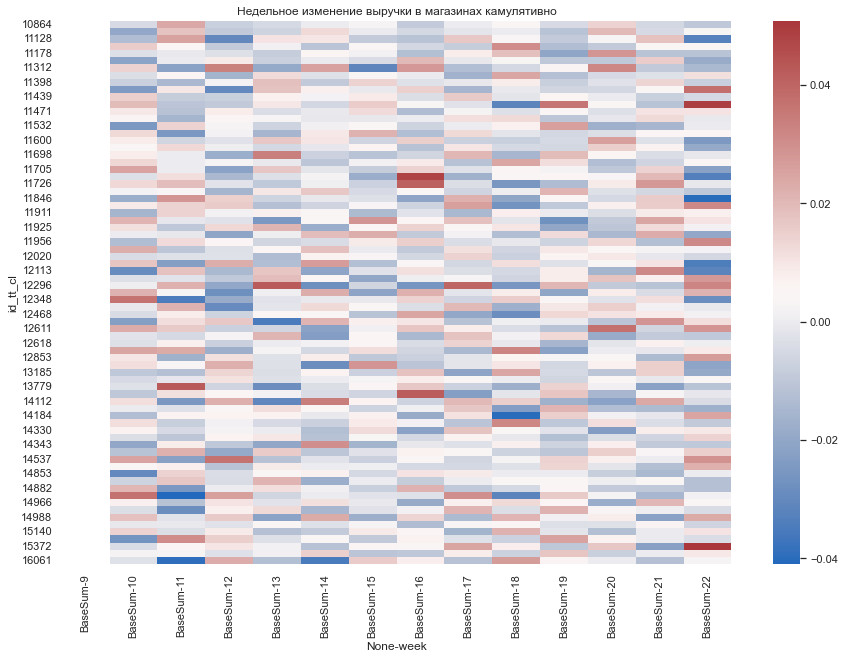

In [7]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_week_diff, cmap='vlag')
plt.title('Недельное изменение выручки в магазинах камулятивно');

Преобразуем df_week_diff так чтобы найти недели с минимальными продажами 

In [8]:
df_week_diff = df_week_diff.loc[:,'BaseSum']

In [9]:
df_week_diff = df_week_diff.fillna(0)

Делаем лист с худшими неделями

In [10]:
df_list = []
for column in df_week_diff.drop(9,axis=1):
    #print(column)
    df_temp = df_week_diff.nsmallest(n=5,columns = column)
    df_temp['shop'] = df_temp.index.astype(int)
    df_temp['week'] = column
    df_temp2 = df_temp[['shop','week', column]]
    df_temp2.columns = ['shop','week', 'val']
    df_list.append(df_temp2)

worst_weeks = pd.concat(df_list)
worst_weeks = worst_weeks.reset_index(drop=True)


In [11]:
top_worst_weeks=worst_weeks.sort_values(by = ['val']).nsmallest(15,'val')

In [12]:
top_worst_weeks.to_excel('Good_and_bad_week.xlsx')
top_worst_weeks.to_pickle("./Good_and_bad_week.pkl")

Заводим функцию просмотра категорий по магазинам и неделям 

In [13]:
def get_category_sales(shop_num, week_num):
    #выбираем из чеков продажи по конкретному магазину и конкретной неделе
    df_checks_with_cat_temp = df_checks_with_cat[(df_checks_with_cat['id_tt_cl']==shop_num) & (df_checks_with_cat['week'] == week_num)]
    #сторим Pivot таблица
    df_category_pivot_sum_temp = df_checks_with_cat_temp.pivot_table(columns=['name_gr'],index=['id_tt_cl'],values = ['BaseSum'],aggfunc= 'sum',fill_value=0).reset_index()
    #исправляем форматирование таблицы 
    df_category_pivot_sum_temp = pd.concat([df_category_pivot_sum_temp['id_tt_cl'].to_frame(),df_category_pivot_sum_temp.loc[:,'BaseSum']], axis=1)
    #добавляем суммарное количество проданных товаров
    df_category_pivot_sum_temp['overal_sum'] = df_category_pivot_sum_temp.drop('id_tt_cl',axis=1).sum(axis=1)
    #заполняем каждое значение датафрейма процентов от общих продаж
    for column in df_category_pivot_sum_temp.drop(['id_tt_cl','overal_sum'],axis=1):
        df_category_pivot_sum_temp[column] = df_category_pivot_sum_temp[column].div(df_category_pivot_sum_temp['overal_sum']/100)
    del df_category_pivot_sum_temp['overal_sum']
    return df_category_pivot_sum_temp
    


In [14]:
df_list = []
for num, row in top_worst_weeks.iterrows():
    temp_df = get_category_sales(row['shop'] , row['week'])
    #print(temp_df)
    df_list.append(temp_df)

n_worst_weeks = pd.concat(df_list) 
del n_worst_weeks['id_tt_cl']
n_worst_weekst_t = n_worst_weeks.transpose().fillna(0)

In [15]:
n_worst_weekst_t['worst'] = n_worst_weekst_t.median(numeric_only=True, axis=1)

In [16]:
categories_in_good_and_bad_shops_by_sum = pd.read_pickle("./categories_in_good_and_bad_shops_by_sum.pkl")

In [17]:
categories_in_good_and_bad_shops_by_sum.head(3)

,good,bad,average
Айс ВкусВилл,0.062433,0.220147,0.309218
Алкоголь,1.574279,1.439297,1.314509
Архив,0.255205,0.226919,0.212740


In [18]:
overal = pd.concat([categories_in_good_and_bad_shops_by_sum, n_worst_weekst_t['worst']], axis = 1).fillna(0)

<AxesSubplot:>

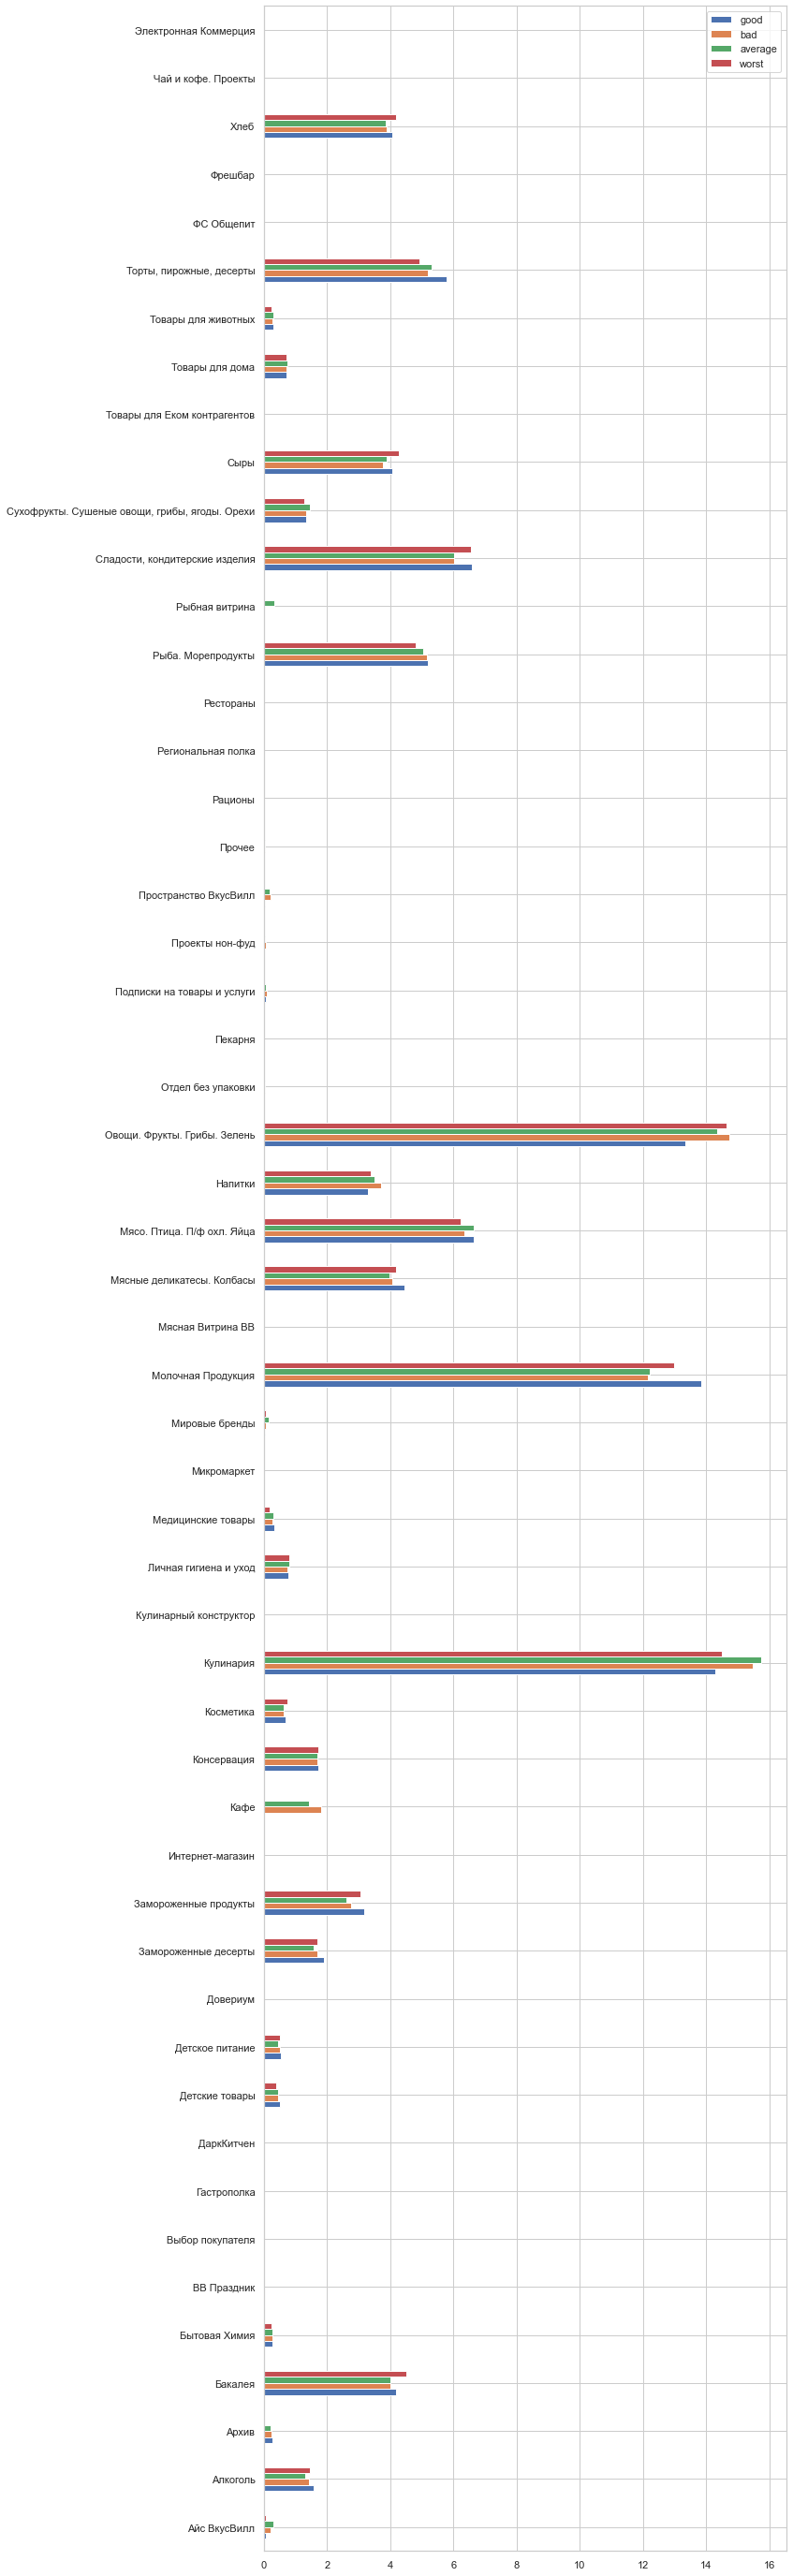

In [160]:
overal.plot(kind="barh",figsize=(10,50))